Check-worthiness of tweets: Given a tweet, predict whether it is worth fact-checking. This task is defined with binary labels: Yes and No.. This is a classification task. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D, Conv1D, GlobalMaxPooling1D 
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

In [21]:
# output directory name:
output_dir = 'model_output/CLEF/conv'

# training:
epochs = 4
batch_size = 8

# vector-space embedding: 
n_dim = 64
n_unique_words = 5000 
pad_type = trunc_type = 'pre'
drop_embed = 0.2 

# convolutional layer architecture:
n_conv = 256 # filters, a.k.a. kernels
k_conv = 3 # kernel length

# dense layer architecture: 
n_dense = 256
dropout = 0.2

In [3]:
data = pd.read_table("./clef/CT22_english_1A_checkworthy_train.tsv")

In [12]:
data.head()

,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1.359351e+18,http://twitter.com/user/status/135935094335617...,"India's gift of 100,000 COVID-19 vaccines arri...",0
1,COVID-19,1.370008e+18,http://twitter.com/user/status/137000807648978...,As part of the ongoing nationwide vaccination ...,0
2,COVID-19,1.367727e+18,http://twitter.com/user/status/136772673004420...,"Pleased to receive 50,000 doses of Covid-19 va...",0
3,COVID-19,1.369888e+18,http://twitter.com/user/status/136988848341471...,Four former presidents have banded together fo...,0
4,COVID-19,1.368585e+18,http://twitter.com/user/status/136858518750069...,WSJ: All three of Russia's main intelligence s...,1


In [9]:
data.shape

(2122, 5)

In [10]:
devdata = pd.read_table("./clef/CT22_english_1A_checkworthy_dev.tsv")

In [13]:
devdata.shape

(195, 5)

In [14]:
devdata.head()

,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1367961367882444800,http://twitter.com/user/status/136796136788244...,Native American communities have been hit hard...,0
1,COVID-19,1367097428785000451,http://twitter.com/user/status/136709742878500...,ALERT: CVS Pharmacy is now offering COVID-19 v...,0
2,COVID-19,1352028219063603202,http://twitter.com/user/status/135202821906360...,#COVID19 vaccines are an important tool to hel...,0
3,COVID-19,1370017732159299585,http://twitter.com/user/status/137001773215929...,Pfizer reports that IRL the vaccine is 97% eff...,0
4,COVID-19,1368105316315918336,http://twitter.com/user/status/136810531631591...,Vaccines are complex medicines. Europeans can ...,0


In [17]:
y_train = data.class_label
y_valid = devdata.class_label 
x_train = data.tweet_text
x_valid = devdata.tweet_text

In [18]:
tokenizer = Tokenizer(
    num_words = 1000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    oov_token = '<UNK',
    char_level=False
)
tokenizer.fit_on_texts(x_train)

In [19]:
# Get our training data word index
word_index = tokenizer.word_index
print("Word index:\n", word_index)

Word index:
 {'<UNK': 1, 'the': 2, 'and': 3, 'to': 4, 'co': 5, 't': 6, 'https': 7, 'vaccines': 8, 'covid': 9, 'of': 10, '19': 11, 'in': 12, 'a': 13, 'for': 14, 'vaccine': 15, 'is': 16, 'are': 17, 'on': 18, 'that': 19, 'have': 20, 'with': 21, 'at': 22, 'this': 23, 'will': 24, 'from': 25, 'by': 26, 'be': 27, 'more': 28, 'has': 29, 'it': 30, 'we': 31, 'as': 32, 'all': 33, 'you': 34, 'people': 35, 'coronavirus': 36, 'not': 37, 'get': 38, 'covid19': 39, 'amp': 40, 'about': 41, 'health': 42, 'first': 43, '1': 44, 'now': 45, 'who': 46, 'i': 47, 'their': 48, 'our': 49, 'they': 50, 'us': 51, 'doses': 52, 'can': 53, 'been': 54, 'new': 55, 'an': 56, 'or': 57, 'one': 58, 'up': 59, 'countries': 60, 'but': 61, '2': 62, 'effective': 63, 'than': 64, 'against': 65, '000': 66, 'your': 67, 'no': 68, 'today': 69, 'pfizer': 70, 'out': 71, 'other': 72, 'safe': 73, 'world': 74, 'pandemic': 75, 'was': 76, 'after': 77, 'available': 78, 'over': 79, 'india': 80, '3': 81, 'vaccination': 82, 'march': 83, 'if': 84,

In [22]:
# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(x_train)

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen, value=0.0)

# Output the results of our work

print("\nTraining sequences:\n", train_sequences)



Training sequences:
 [[848, 1, 10, 172, 66, 9, 11, 8, 397, 1, 1, 69, 23, 76, 13, 192, 991, 849, 14, 33, 1, 3, 47, 276, 4, 297, 602, 234, 1, 14, 163, 850, 1, 3, 1, 992, 12, 1, 51, 4, 27, 2, 1, 10, 119, 8, 7, 6, 5, 1], [32, 286, 10, 2, 1, 1, 82, 196, 19, 29, 603, 28, 64, 1, 66, 35, 91, 128, 1, 3, 43, 1, 1, 1, 97, 48, 9, 11, 8, 22, 1, 1, 243, 7, 6, 5, 1], [851, 4, 142, 165, 66, 52, 10, 9, 11, 8, 25, 80, 1, 469, 604, 10, 1, 1, 16, 993, 4, 2, 604, 10, 80, 1, 3, 72, 1, 60, 14, 48, 1, 1, 4, 2, 254, 65, 39, 1], [357, 605, 852, 20, 1, 398, 14, 138, 277, 1, 1, 1, 426, 1, 4, 606, 607, 12, 9, 11, 8, 1, 533, 33, 1, 111, 1, 65, 2, 89, 7, 6, 5, 1], [1, 33, 197, 10, 1, 1, 853, 567, 1, 1, 3, 1, 1, 268, 125, 568, 3, 1, 453, 244, 1, 4, 159, 608, 41, 1, 3, 140, 8, 12, 56, 1, 4, 743, 454, 12, 160, 7, 6, 5, 1, 136, 1], [1, 1, 24, 1, 163, 1, 1, 1, 4, 197, 1, 1, 12, 1, 4, 105, 245, 1, 1, 1, 681, 3, 173, 14, 98, 46, 38, 9, 11, 8, 1, 14, 13, 1, 1, 1, 14, 994, 1, 166, 14, 1, 1, 534, 1, 7, 6, 5, 1], [1, 53, 27, 

In [23]:
print("maxlen: ", maxlen)
print("\nPadded training sequences:\n", train_padded)
print("\nPadded training shape:", train_padded.shape)
print("Training sequences data type:", type(train_sequences))
print("Padded Training sequences data type:", type(train_padded))

maxlen:  98

Padded training sequences:
 [[  0   0   0 ...   6   5   1]
 [  0   0   0 ...   6   5   1]
 [  0   0   0 ...  65  39   1]
 ...
 [  0   0   0 ...  14 145   1]
 [  0   0   0 ...   6   5   1]
 [  0   0   0 ...   6   5   1]]

Padded training shape: (2122, 98)
Training sequences data type: <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'>


In [24]:
test_sequences = tokenizer.texts_to_sequences(x_valid)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen, value=0.0)

print("Testing sequences:\n", test_sequences)
print("\nPadded testing sequences:\n", test_padded)
print("\nPadded testing shape:",test_padded.shape)

#x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

Testing sequences:
 [[1, 304, 251, 20, 54, 788, 795, 26, 9, 11, 61, 392, 4, 2, 900, 42, 863, 3, 810, 1, 21, 1, 548, 874, 3, 1, 900, 281, 28, 64, 352, 66, 8, 20, 322, 54, 153, 21, 28, 18, 2, 202], [1, 429, 927, 16, 45, 572, 9, 11, 8, 12, 1, 4, 330, 620, 316, 1, 3, 1, 108, 3, 208, 7, 6, 5, 1], [39, 8, 17, 56, 305, 1, 4, 105, 275, 2, 75, 32, 10, 618, 11, 28, 64, 537, 185, 88, 35, 113, 97, 48, 43, 106, 10, 13, 9, 11, 15, 10, 98, 28, 64, 62, 88, 113, 97, 209, 52, 3, 17, 532, 91, 28, 7, 6, 5, 1, 7, 6, 5, 1], [70, 242, 19, 1, 2, 15, 16, 1, 63, 65, 1, 9, 3, 1, 63, 65, 1, 152, 119, 8, 17, 13, 1, 3, 312, 1, 1, 7, 6, 5, 1], [8, 17, 1, 636, 1, 53, 607, 19, 9, 11, 8, 1, 12, 2, 213, 20, 1, 146, 1, 184, 3, 384, 3, 17, 112, 307, 18, 2, 1, 84, 216, 3, 1, 17, 1, 205, 28, 41, 2, 724, 1, 1, 7, 6, 5, 1], [895, 10, 1, 129, 57, 1, 17, 1, 1, 4, 287, 2, 15, 178, 1, 14, 1, 1, 251, 1, 107, 23, 24, 235, 13, 385, 202, 4, 651, 589, 2, 1, 3, 38, 28, 8, 12, 925, 7, 6, 5, 1], [1, 193, 1, 1, 1, 10, 531, 1, 12, 1, 35, 1

In [25]:
model = Sequential()

#first hidden layer
model.add(Embedding(n_unique_words, n_dim, input_length=maxlen)) 
model.add(SpatialDropout1D(drop_embed))

# second hidden layer
model.add(Conv1D(n_conv, k_conv, activation='relu')) # conv2D conv3d for images
# model.add(Conv1D(n_conv, k_conv, activation='relu'))
model.add(GlobalMaxPooling1D())

#third hidden layer
model.add(Dense(n_dense, activation='relu'))
model.add(Dropout(dropout))

#output
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 98, 64)            320000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 98, 64)           0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 96, 256)           49408     
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0

In [91]:
tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5
)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.BinaryAccuracy()])

In [92]:
modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [93]:
model.fit(np.array(train_padded), np.array(y_train), 
          batch_size=batch_size, 
          epochs=epochs, verbose=1, 
          validation_data=(np.array(test_padded), np.array(y_valid)), 
          callbacks=[modelcheckpoint])

Epoch 1/4
266/266 [==============================] - 1s 4ms/step - loss: 0.0139 - binary_accuracy: 0.9976 - val_loss: 1.0553 - val_binary_accuracy: 0.8051
Epoch 2/4
266/266 [==============================] - 1s 4ms/step - loss: 0.0133 - binary_accuracy: 0.9953 - val_loss: 1.7154 - val_binary_accuracy: 0.7897
Epoch 3/4
266/266 [==============================] - 1s 4ms/step - loss: 0.0234 - binary_accuracy: 0.9920 - val_loss: 1.2413 - val_binary_accuracy: 0.7897
Epoch 4/4
266/266 [==============================] - 1s 4ms/step - loss: 0.0027 - binary_accuracy: 0.9986 - val_loss: 1.3877 - val_binary_accuracy: 0.7487


In [94]:
len(test_sequences)

195

In [95]:
len(train_sequences)

2122

In [96]:
model.load_weights(output_dir+"/weights.04.hdf5") 

In [97]:
testdata = pd.read_table("./clef/CT22_english_1A_checkworthy_test_gold.tsv")

In [98]:
testdata.head()

,topic,tweet_id,tweet_url,tweet_text,class_label
0,COVID-19,1425267281202909184,http://twitter.com/user/status/142526728120290...,i was a vaccine checker tonight at my venue an...,0
1,COVID-19,1387113304959504384,http://twitter.com/user/status/138711330495950...,I asked the nurse giving my vaccine if I could...,0
2,COVID-19,1379498353294069760,http://twitter.com/user/status/137949835329406...,When the polio vaccine dropped in 1955 people ...,0
3,COVID-19,1369843850223759362,http://twitter.com/user/status/136984385022375...,I asked my mom if she felt any side effects fr...,0
4,COVID-19,1352425395375759363,http://twitter.com/user/status/135242539537575...,A 6-year old ballet student asked me today if ...,0


In [99]:
testdata.shape

(149, 5)

In [100]:
x_test = testdata['tweet_text']

In [101]:
test_xsequences = tokenizer.texts_to_sequences(x_test)
test_xpadded = pad_sequences(test_xsequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen, value=0.0)

In [102]:
y_hat = model.predict(test_xpadded)

5/5 [==============================] - 0s 3ms/step


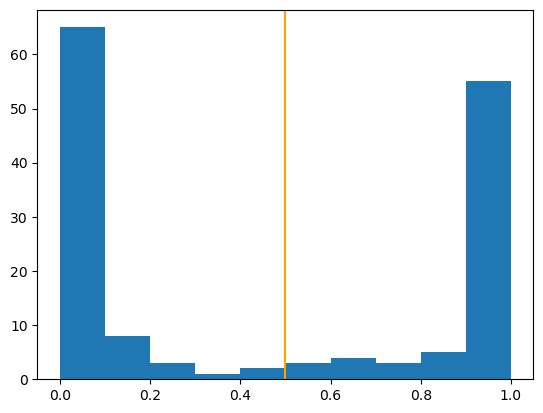

In [103]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [104]:
y = testdata['class_label'].astype(np.int64)
y.value_counts()

0    110
1     39
Name: class_label, dtype: int64

In [105]:
"{:0.2f}".format(roc_auc_score(y, y_hat)*100.0)

'53.50'

In [106]:
print("Evaluate on test data")
results = model.evaluate(test_xpadded, y, batch_size=batch_size)
print("test loss, test acc:", results)

Evaluate on test data
19/19 [==============================] - 0s 1ms/step - loss: 2.8224 - binary_accuracy: 0.5235
test loss, test acc: [2.8223745822906494, 0.5234899520874023]
